Some testing on a sin wave pattern to establish an LSTM's ability to predict

Much of the code based off this tutorial here: https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7

In [134]:
import numpy as np # Standard python maths library

import matplotlib.pyplot as plt # Graph plotting tools
plt.rcParams['figure.figsize'] = [30, 5] # matplotlib settings, define size of graph. Edit if the graphs do not fit on your screen

import torch # Machine learning libary being used for LSTM
from torch import nn # Commonly used module of torch library


Building a noisy sine wave to get a pattern for SARIMA and LSTM to solve

In [135]:
N = 1000 # number of samples
T = 20 # width of the wave
stDev = 0.5 # Strength of noise


x = np.arange(N) / N
base_y = np.sin(np.arange(N)/1.0/T).astype(np.float32) # Pure sin wave
y = base_y + np.random.normal(loc=0, scale=stDev, size=N) # Add noise to sample

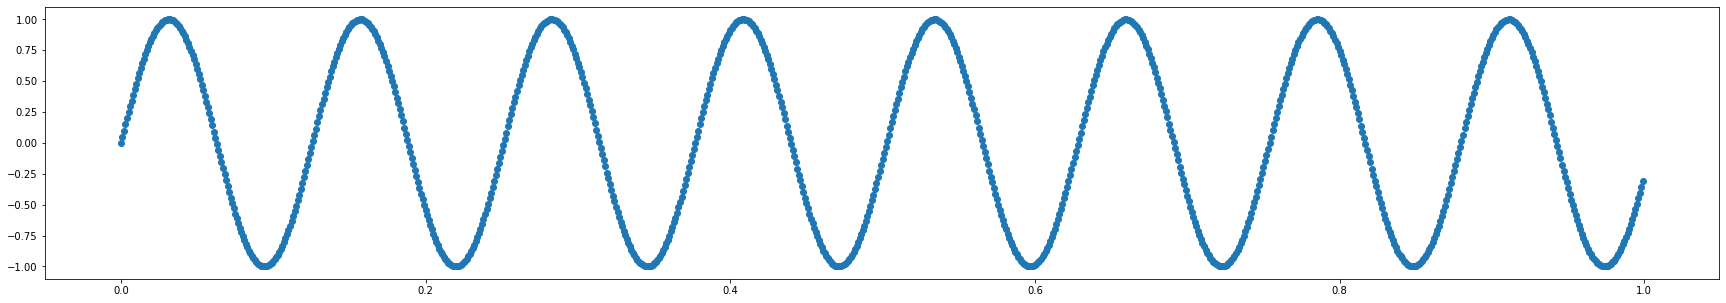

In [136]:
# Plot of pure sin wave
plt.scatter(x, base_y)

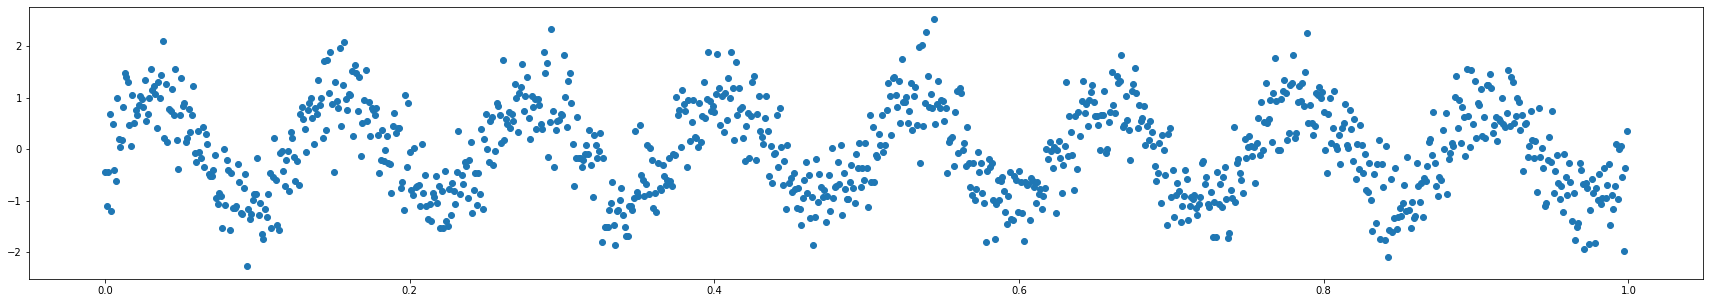

In [137]:
# Plot of the pure sin wave with added noise
plt.scatter(x, y)

Building the LSTM occurs in multiple parts
 - Build the LSTM class
 - Build a training loop
 - Prepare the data
 
Firstly, building the LSTM class:

In [138]:
class LSTM(nn.Module):
    def __init__(self, hidden_layers=16):
        """ Instantiate the LSTM with multiple hidden layers
            In this case, I'm using two hidden layers, and a linear layer to convert the output to a single number """
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        
    def forward(self, y, future_preds=0):
        """ Call the model to make predictions
            h_t and c_t are the hidden and cell states of the lstm layers
            
            This forward function runs through the data one point at a time, and stores the models output for each point
            If future_preds > 0 is passed in, the model with make predictions based on its own output. It is currently very bad at this.
        """
        outputs, num_samples = [], y.size(0)
        h_t = torch.zeros(self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(self.hidden_layers, dtype=torch.float32)
        
        for time_step in y.split(1, dim=0):
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # Mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=0)
        return outputs

In [139]:
def training_loop(n_epochs, model, optimiser, loss_fn, 
                  train_input, train_target, test_input, test_target):
    """ Train a model with provided data
        Ignorning the auto plotting part for now """
    for i in range(n_epochs):
        def closure():
            optimiser.zero_grad()
            out = model(train_input)
            loss = loss_fn(out, train_target)
            loss.backward()
            return loss
        optimiser.step(closure)
        
        # Make future predictions
        with torch.no_grad():
            future = len(test_target)
            pred = model(torch.cat([train_input, test_input], dim=0), future_preds=future)
            loss = loss_fn(pred[-future:], test_target)
            y = pred.detach().numpy()
        
        return (loss, y)

In [140]:
# Prepare the data
train = y[:900]
test = y[900:]

train_x = torch.tensor(train[:-1], dtype=torch.float32)
train_y = torch.tensor(train[1:], dtype=torch.float32)

test_x = torch.tensor(test[:-1], dtype=torch.float32)
test_y = torch.tensor(test[1:], dtype=torch.float32)

# Instantiate the model, loss function and optimiser
model = LSTM()
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.08)

# Train the model
r = training_loop(10, model, optimiser, criterion, train_x, train_y, test_x, test_y)

999 1000


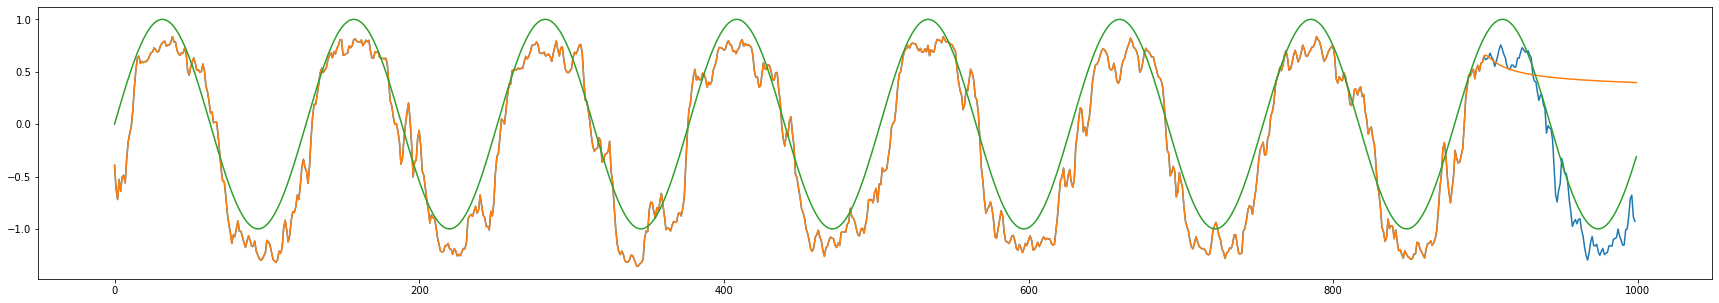

In [141]:
# Plot some graphs of the models performance compared to the true underlying sin wave pattern
with torch.no_grad():
    fullTrain = model(torch.tensor(y[:-1], dtype=torch.float32))
    predictLast = model((torch.tensor(y[:-len(test)], dtype=torch.float32)), future_preds=(len(test)))

    
print(len(fullTrain), len(predictLast))

plt.plot(fullTrain, label="Full")
plt.plot(predictLast, label="Predicting")
plt.plot(base_y)
plt.show()

Now to build a sarimax model to compare against

In [142]:
import statsmodels.api as sm

Check autocorrelation. Its very pretty.

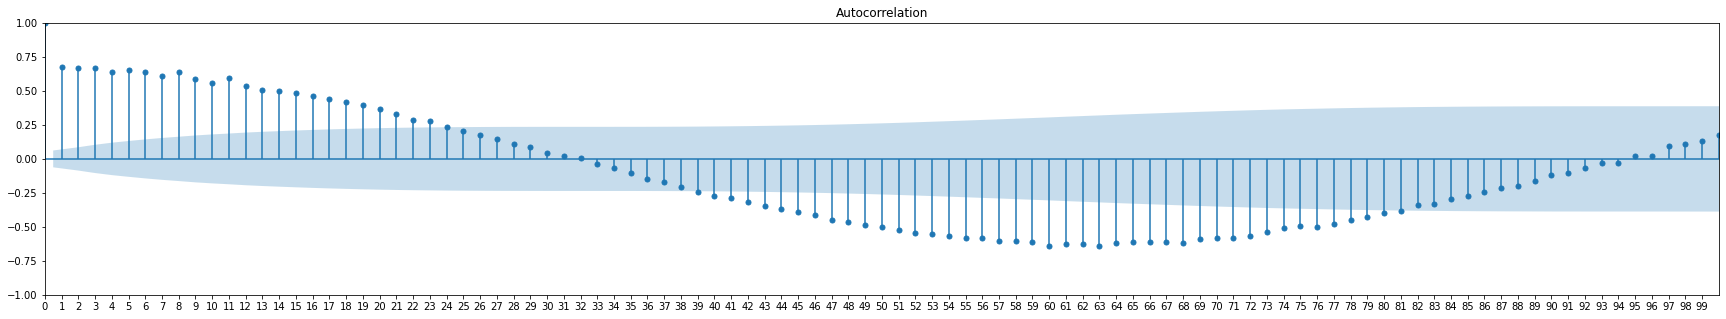

In [143]:
axis = plt.subplot(ylim=[0, 1], xlim=[0, 100], xticks=range(100))

fig = sm.graphics.tsa.plot_acf(np.array(y), lags=100, ax=axis)

Check partial autocorrelation. It is significantly less pretty. 

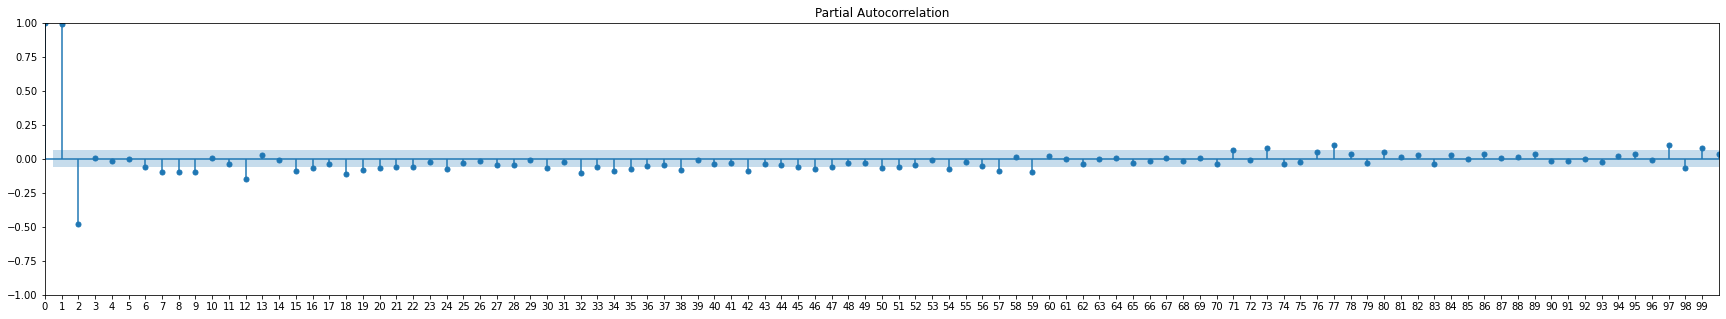

In [144]:
axis = plt.subplot(ylim=[-0.1, 0.1], xlim=[0, 100], xticks=range(100))

fig = sm.graphics.tsa.plot_pacf(np.array(fullTrain), lags=100, ax=axis)

Train a basic SARIMA model

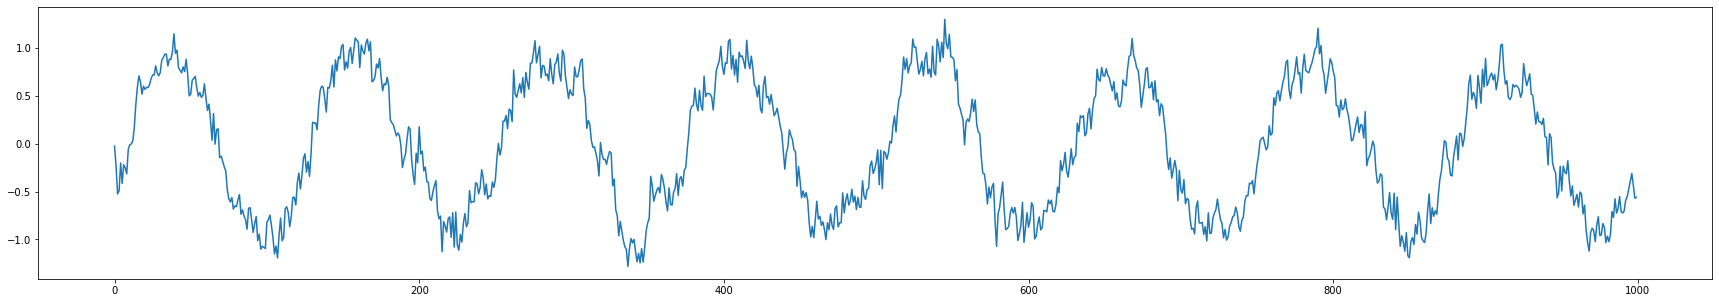

In [145]:
model = sm.tsa.arima.ARIMA(endog=np.array(y), order=(1, 0, 1), seasonal_order=(1, 0, 1, 61))
res = model.fit()
plt.plot(res.fittedvalues)

Train a more complicated SARIMA model

C:\Users\ray\anaconda3\envs\MscThesis\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ray\anaconda3\envs\MscThesis\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ray\anaconda3\envs\MscThesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


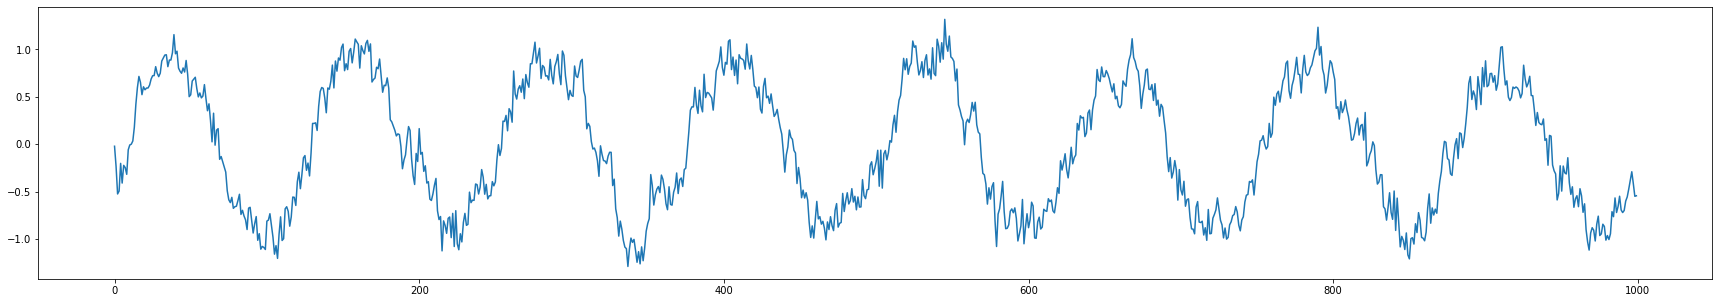

In [146]:
model = sm.tsa.arima.ARIMA(endog=np.array(y), order=(2, 0, 2), seasonal_order=(2, 0, 2, 61))
res = model.fit()
plt.plot(res.fittedvalues)

Plot it all together

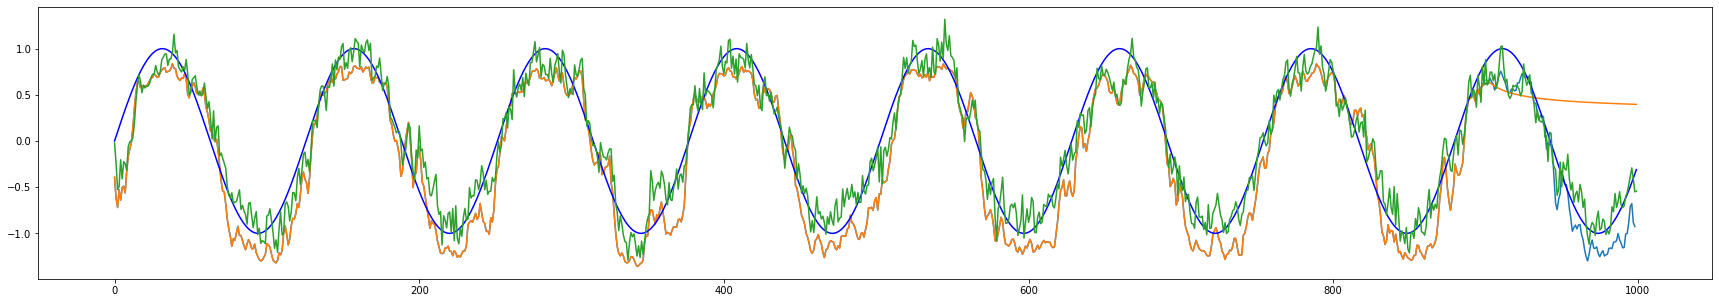

In [147]:
plt.plot(fullTrain, label="Full")
plt.plot(predictLast, label="Predicting")
plt.plot(base_y, color="b")
plt.plot(res.fittedvalues)
plt.show()

Here we can compare the SARIMA model (Green) and the LSTM model (Orange/Light Blue) against the baseline sin wave (dark blue)

~Skipping over the first 200 points to allow the SARIMA model to settle, we can see a noticable stability in the LSTM model compared to SARIMA. Over time, the sarima model more closely approximates the true sin wave.~
Error on my part in the syntax when designing theSARIMA model. The better designed model consistently fits the underlying sin wave.

Curiously, the LSTM consistently undershoots the peaks over the sin waves, but not the troughs.

At the points where the LSTM results split into the blue is a difference in predicting methods. For the orange line, the input data ends at that split, and it keeps predicting based on its own output. With some adjusting it may be possible to stop it flatlining immediately, but I've not worked that out yet.

The blue line is where the model is making predictions on data it has not seen before, but is still being fed new data. For each point, we show it to the model and record its output. The next input to the model is the next true value, rather than the models own output.

### Testing more complicated series

Moving Average

In [148]:
N = 1000 # number of samples
T = 20 # width of the wave
stDev = 0.5 # Strength of noise
averageMovement = 4


x = np.arange(N) / N
base_y = np.sin(np.arange(N)/1.0/T).astype(np.float32) # Pure sin wave
base_y += np.arange(N) / (N / averageMovement)
y = base_y + np.random.normal(loc=0, scale=stDev, size=N) # Add noise to sample

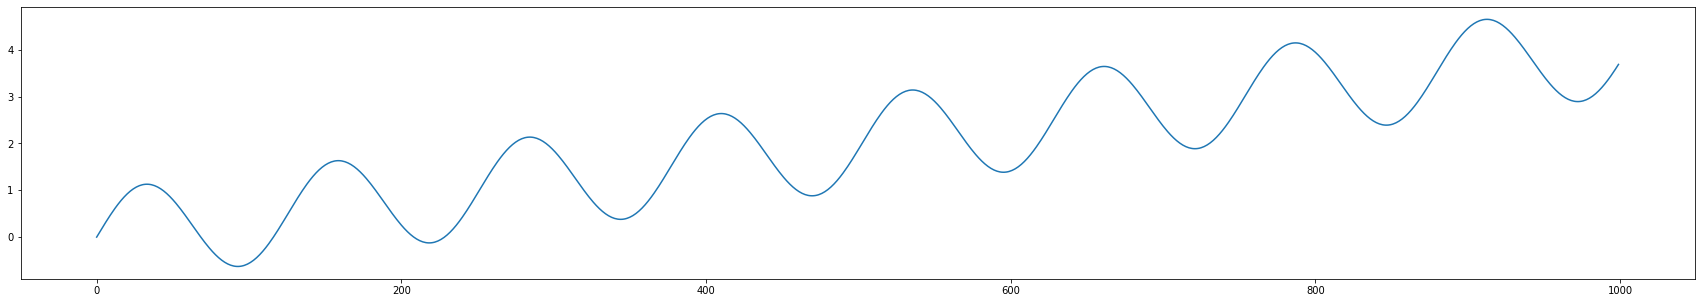

In [149]:
plt.plot(base_y)

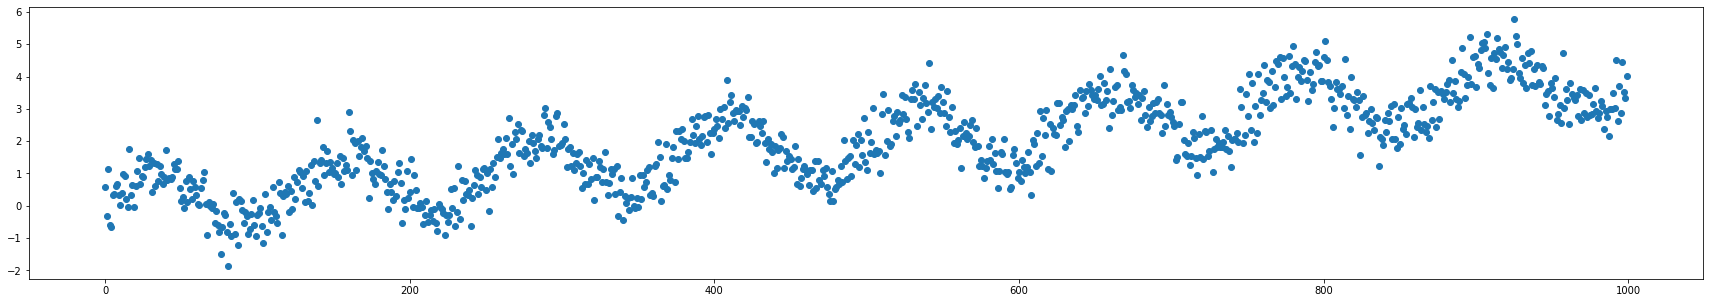

In [150]:
plt.scatter(np.arange(1000), y)

In [151]:
# Prepare the data
train = y[:900]
test = y[900:]

train_x = torch.tensor(train[:-1], dtype=torch.float32)
train_y = torch.tensor(train[1:], dtype=torch.float32)

test_x = torch.tensor(test[:-1], dtype=torch.float32)
test_y = torch.tensor(test[1:], dtype=torch.float32)

# Instantiate the model, loss function and optimiser
model = LSTM()
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.08)

# Train the model
r = training_loop(10, model, optimiser, criterion, train_x, train_y, test_x, test_y)

999 1000


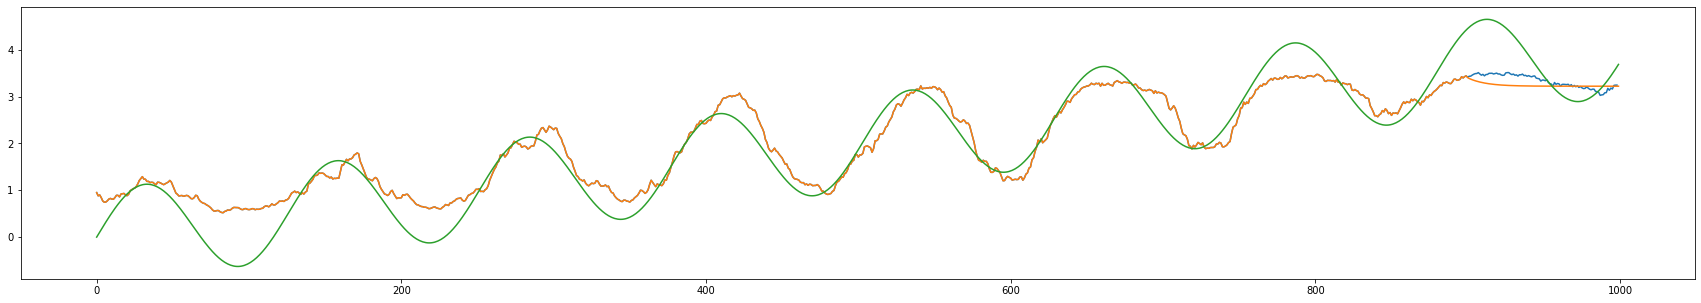

In [152]:
# Plot some graphs of the models performance compared to the true underlying sin wave pattern
with torch.no_grad():
    fullTrain = model(torch.tensor(y[:-1], dtype=torch.float32))
    predictLast = model((torch.tensor(y[:-len(test)], dtype=torch.float32)), future_preds=(len(test)))

    
print(len(fullTrain), len(predictLast))

plt.plot(fullTrain, label="Full")
plt.plot(predictLast, label="Predicting")
plt.plot(base_y)
plt.show()

Seems to have trouble adjusting to the moving average

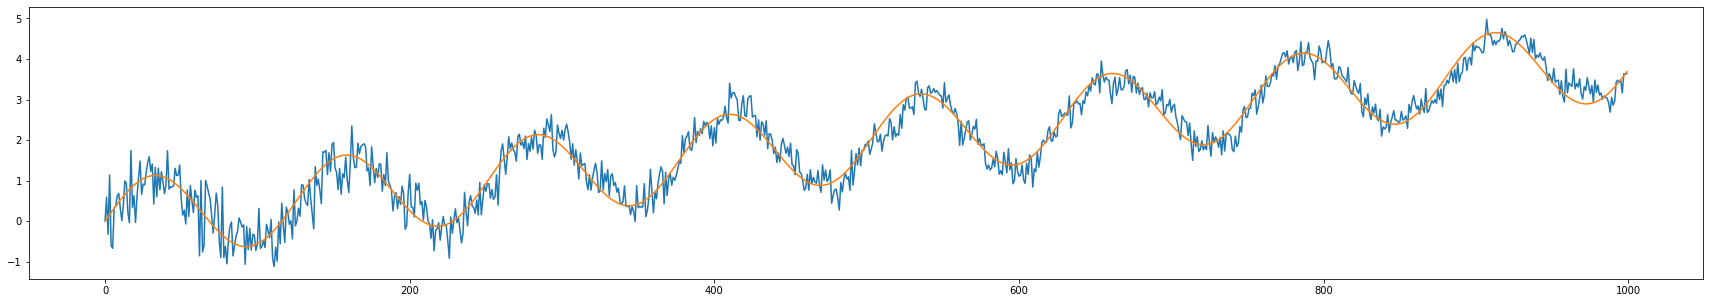

In [153]:
model = sm.tsa.arima.ARIMA(endog=np.array(y), order=(2,1,2), seasonal_order=(2, 1, 2, 61))
res = model.fit()

plt.plot(res.fittedvalues)
plt.plot(base_y)
plt.show()

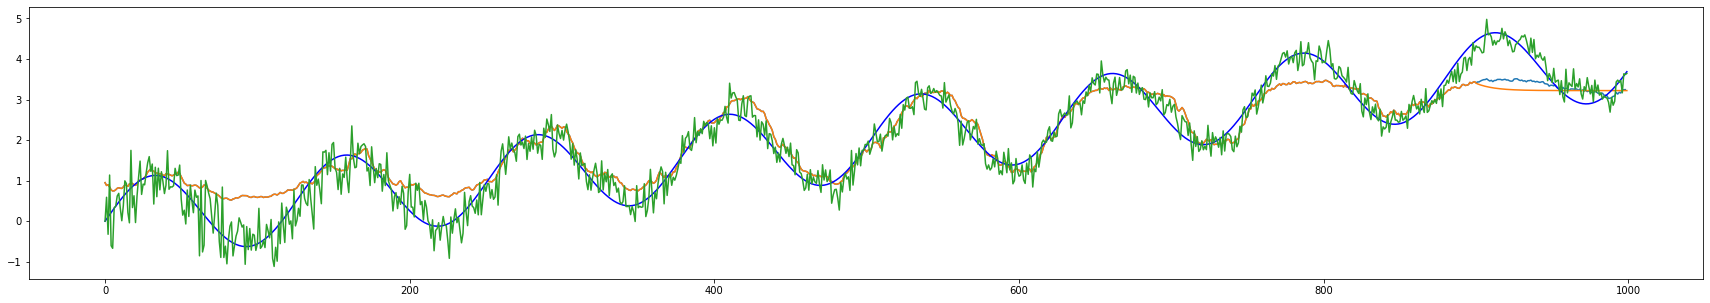

In [154]:
plt.plot(fullTrain, label="Full")
plt.plot(predictLast, label="Predicting")
plt.plot(base_y, color="b")
plt.plot(res.fittedvalues)
plt.show()

#### Fourier Series

In [389]:
N = 1000 # number of samples
T1 = 20 # width of the wave
M1 = 1

T2 = 7
M2 = 0.7

T3 = 27
M3 = 0.3

stDev = 0.5 # Strength of noise
averageMovement = 4


x = np.arange(N) / N
base_y = np.sin(np.arange(N)*M1/T1).astype(np.float32)  \
       + np.sin(np.arange(N)*M2/T2).astype(np.float32) \
       + np.sin(np.arange(N)*M3/T2).astype(np.float32)
y = base_y + np.random.normal(loc=0, scale=stDev, size=N) # Add noise to sample

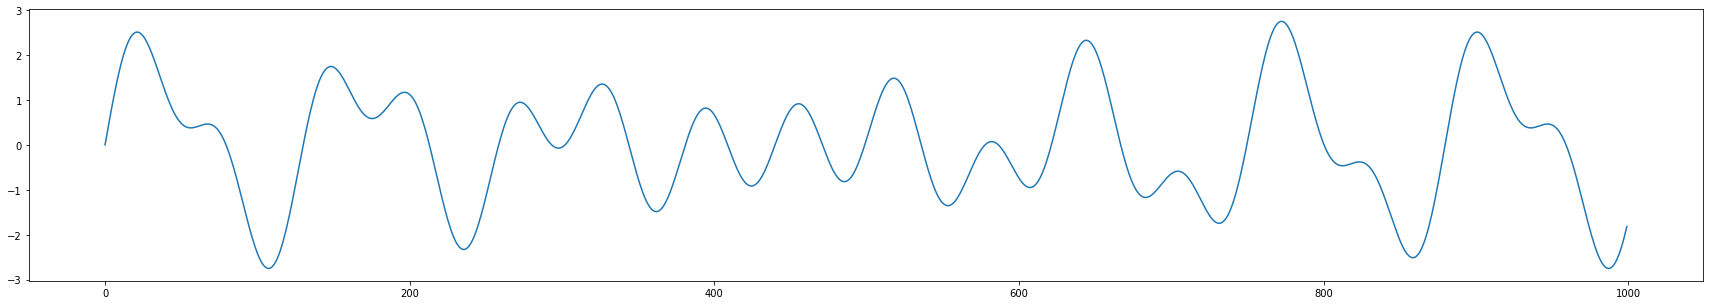

In [390]:
plt.plot(base_y)

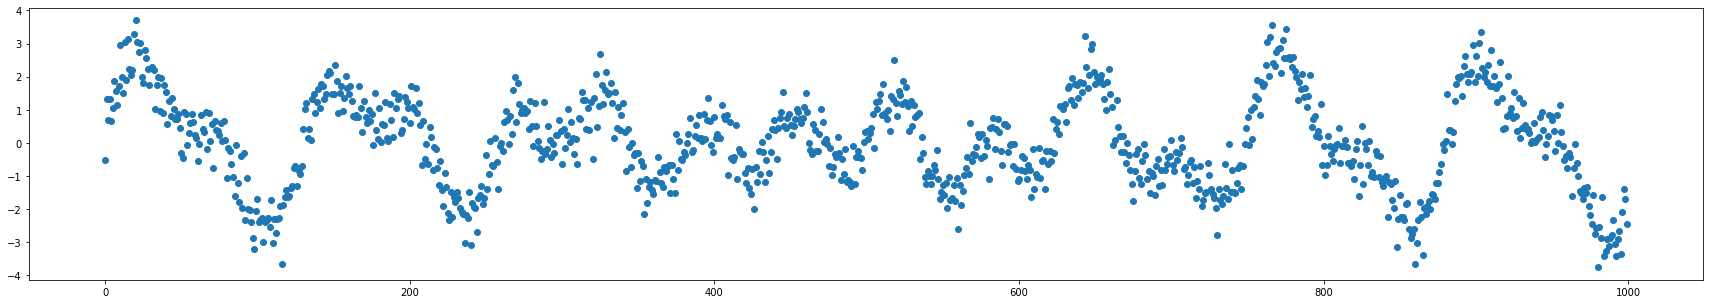

In [391]:
plt.scatter(np.arange(1000), y)

In [158]:
# Prepare the data
train = y[:900]
test = y[900:]

train_x = torch.tensor(train[:-1], dtype=torch.float32)
train_y = torch.tensor(train[1:], dtype=torch.float32)

test_x = torch.tensor(test[:-1], dtype=torch.float32)
test_y = torch.tensor(test[1:], dtype=torch.float32)

# Instantiate the model, loss function and optimiser
model = LSTM()
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.08)

# Train the model
r = training_loop(10, model, optimiser, criterion, train_x, train_y, test_x, test_y)

999 1000


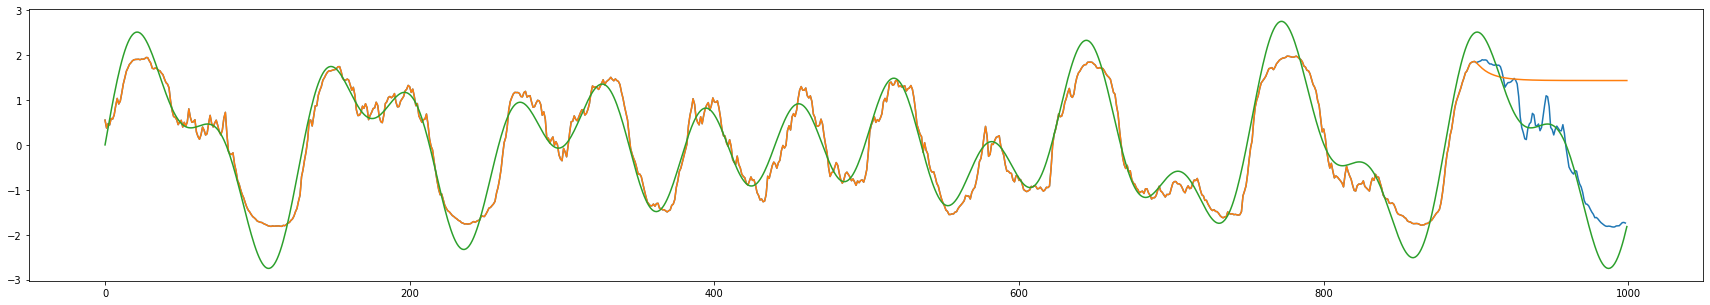

In [159]:
# Plot some graphs of the models performance compared to the true underlying sin wave pattern
with torch.no_grad():
    fullTrain = model(torch.tensor(y[:-1], dtype=torch.float32))
    predictLast = model((torch.tensor(y[:-len(test)], dtype=torch.float32)), future_preds=(len(test)))

    
print(len(fullTrain), len(predictLast))

plt.plot(fullTrain, label="Full")
plt.plot(predictLast, label="Predicting")
plt.plot(base_y)
plt.show()

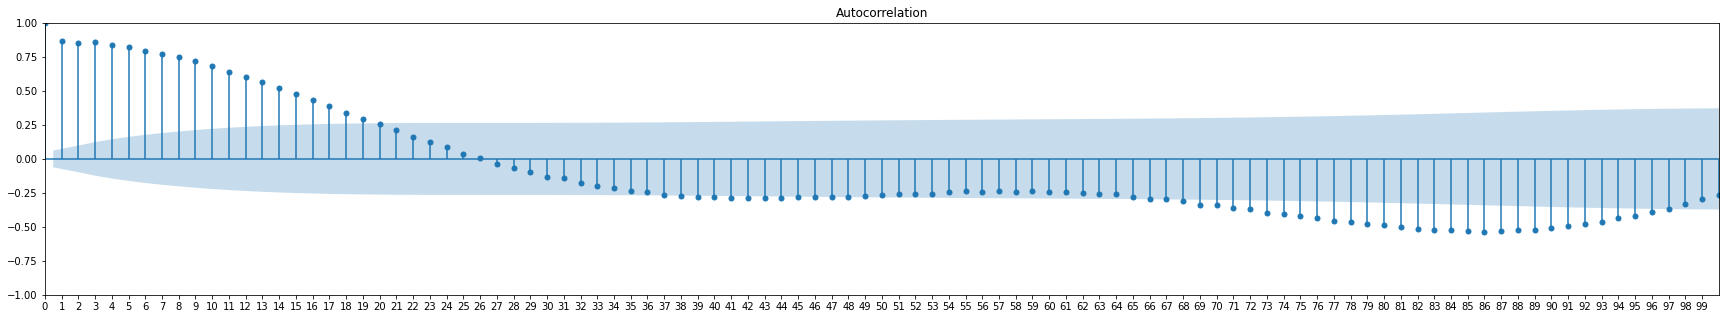

In [160]:
axis = plt.subplot(ylim=[0, 1], xlim=[0, 100], xticks=range(100))

fig = sm.graphics.tsa.plot_acf(np.array(y), lags=100, ax=axis)

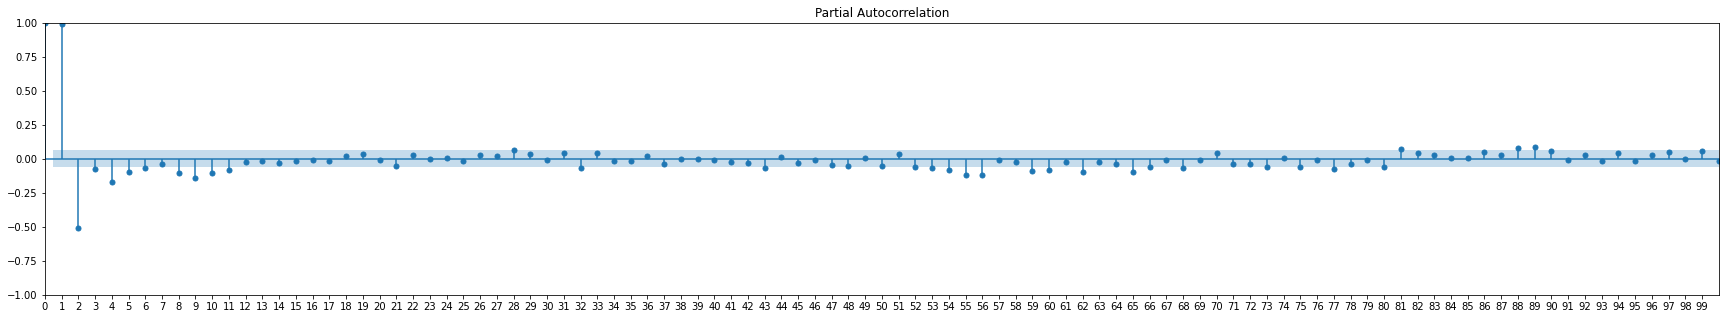

In [161]:
axis = plt.subplot(ylim=[-0.1, 0.1], xlim=[0, 100], xticks=range(100))

fig = sm.graphics.tsa.plot_pacf(np.array(fullTrain), lags=100, ax=axis)

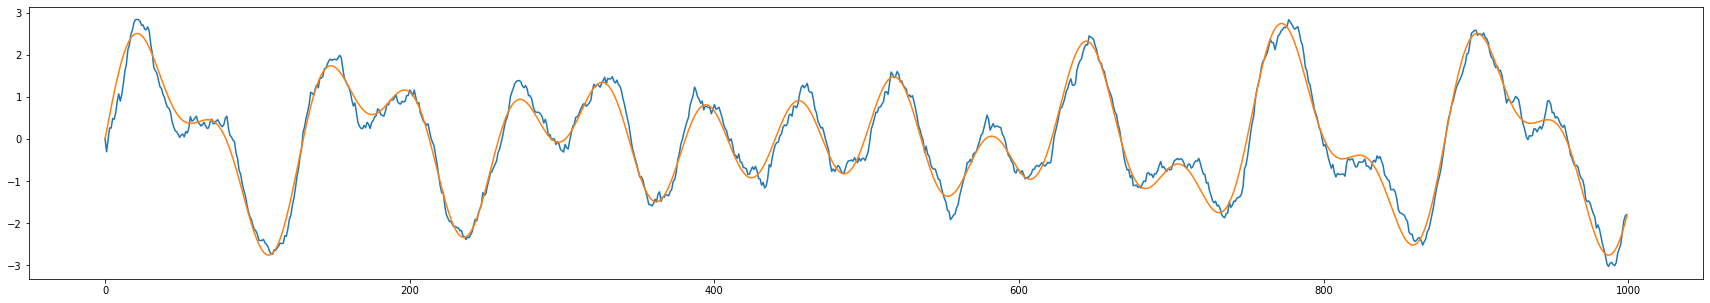

In [163]:
model = sm.tsa.arima.ARIMA(endog=np.array(y), order=(2, 0, 2))
res = model.fit()

plt.plot(res.fittedvalues)
plt.plot(base_y)
plt.show()

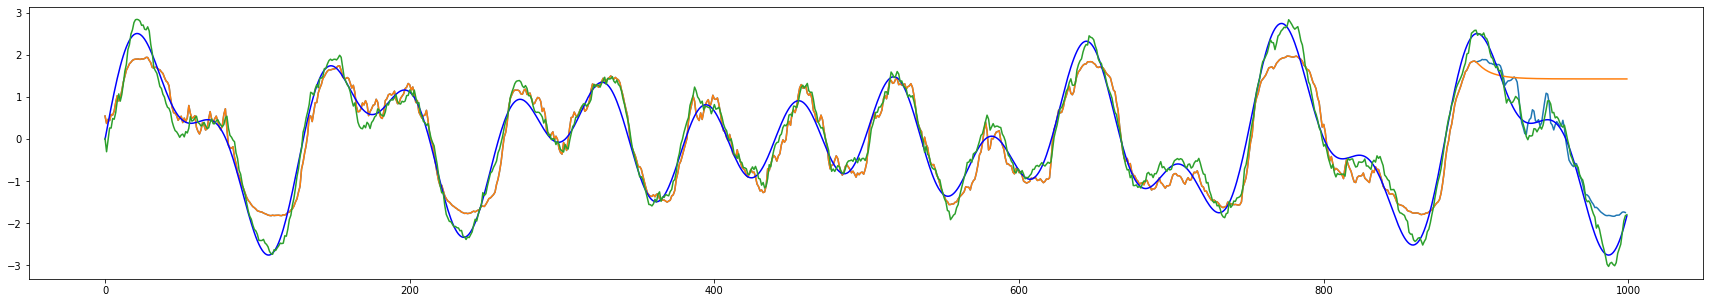

In [164]:
plt.plot(fullTrain, label="Full")
plt.plot(predictLast, label="Predicting")
plt.plot(base_y, color="b")
plt.plot(res.fittedvalues)
plt.show()

Tweaking the LSTM

In [174]:
class LSTM(nn.Module):
    def __init__(self, hidden_layers_1=16, hidden_layers_2=16):
        """ Instantiate the LSTM with multiple hidden layers
            In this case, I'm using two hidden layers, and a linear layer to convert the output to a single number """
        super(LSTM, self).__init__()
        self.hidden_layers_1 = hidden_layers_1
        self.hidden_layers_2 = hidden_layers_2
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers_1)
        self.lstm2 = nn.LSTMCell(self.hidden_layers_1, self.hidden_layers_2)
        self.linear = nn.Linear(self.hidden_layers_2, 1)
        
    def forward(self, y, future_preds=0):
        """ Call the model to make predictions
            h_t and c_t are the hidden and cell states of the lstm layers
            
            This forward function runs through the data one point at a time, and stores the models output for each point
            If future_preds > 0 is passed in, the model with make predictions based on its own output. It is currently very bad at this.
        """
        outputs, num_samples = [], y.size(0)
        h_t = torch.zeros(self.hidden_layers_1, dtype=torch.float32)
        c_t = torch.zeros(self.hidden_layers_1, dtype=torch.float32)
        h_t2 = torch.zeros(self.hidden_layers_2, dtype=torch.float32)
        c_t2 = torch.zeros(self.hidden_layers_2, dtype=torch.float32)
        
        for time_step in y.split(1, dim=0):
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # Mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=0)
        return outputs

In [175]:
# Prepare the data
train = y[:900]
test = y[900:]

train_x = torch.tensor(train[:-1], dtype=torch.float32)
train_y = torch.tensor(train[1:], dtype=torch.float32)

test_x = torch.tensor(test[:-1], dtype=torch.float32)
test_y = torch.tensor(test[1:], dtype=torch.float32)

# Instantiate the model, loss function and optimiser
model = LSTM()
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.5)

# Train the model
r = training_loop(10, model, optimiser, criterion, train_x, train_y, test_x, test_y)

999 1000


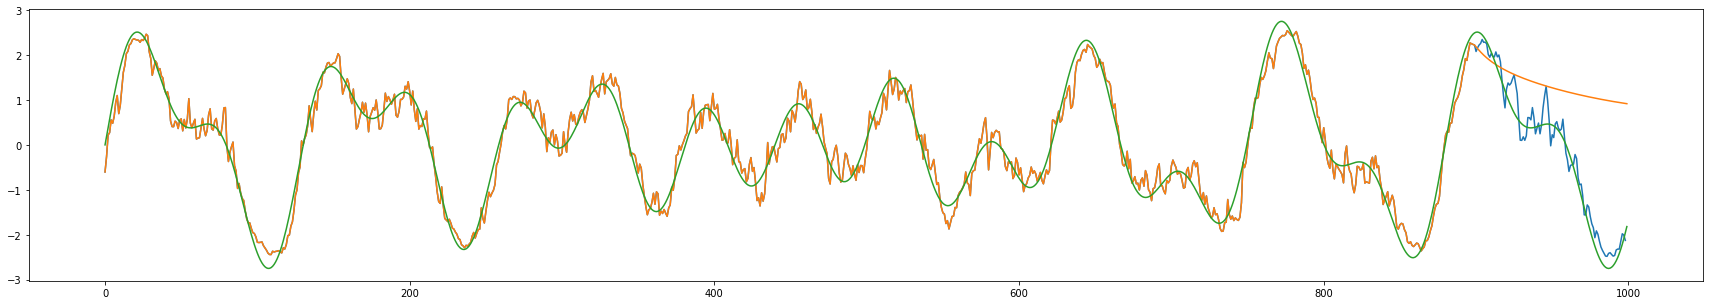

In [176]:
# Plot some graphs of the models performance compared to the true underlying sin wave pattern
with torch.no_grad():
    fullTrain = model(torch.tensor(y[:-1], dtype=torch.float32))
    predictLast = model((torch.tensor(y[:-len(test)], dtype=torch.float32)), future_preds=(len(test)))

    
print(len(fullTrain), len(predictLast))

plt.plot(fullTrain, label="Full")
plt.plot(predictLast, label="Predicting")
plt.plot(base_y)
plt.show()

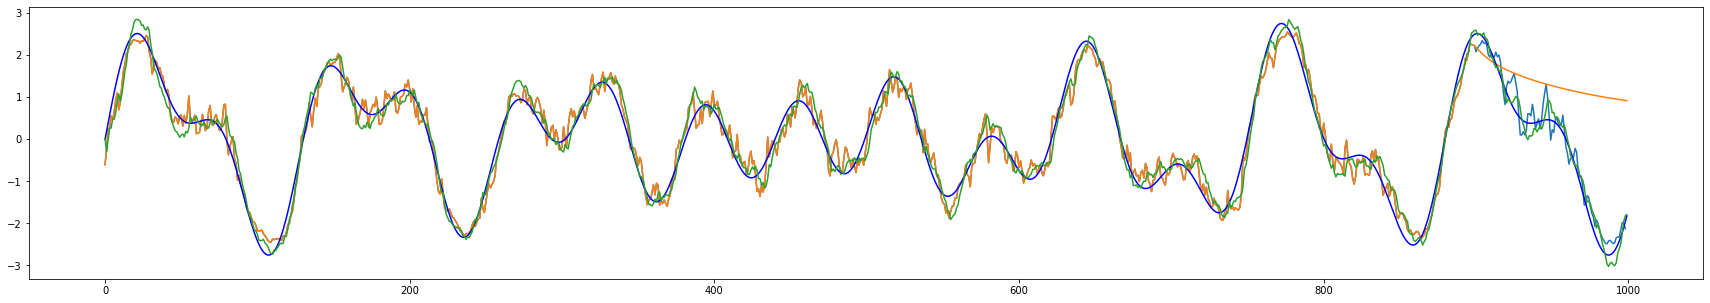

In [177]:
plt.plot(fullTrain, label="Full")
plt.plot(predictLast, label="Predicting")
plt.plot(base_y, color="b")
plt.plot(res.fittedvalues)
plt.show()

Try training with more features

In [399]:
class LSTM_multifeature(nn.Module):
    def __init__(self, input_features, hidden_layers_1=32, hidden_layers_2=32):
        """ Instantiate the LSTM with multiple hidden layers
            In this case, I'm using two hidden layers, and a linear layer to convert the output to a single number """
        super(LSTM_multifeature, self).__init__()
        self.input_features = input_features
        self.hidden_layers_1 = hidden_layers_1
        self.hidden_layers_2 = hidden_layers_2
        self.lstm1 = nn.LSTMCell(self.input_features, self.hidden_layers_1)
        self.lstm2 = nn.LSTMCell(self.hidden_layers_1, self.hidden_layers_2)
        self.linear = nn.Linear(self.hidden_layers_2, 1)
        
        self.last_loss = 0  # For printing purposes during training
        
    def forward(self, y, future_preds=0):
        """ Call the model to make predictions
            h_t and c_t are the hidden and cell states of the lstm layers
            
            This forward function runs through the data one point at a time, and stores the models output for each point
            If future_preds > 0 is passed in, the model with make predictions based on its own output. It is currently very bad at this.
        """
        outputs, num_samples = [], y.shape[0]
        h_t = torch.zeros(1, self.hidden_layers_1, dtype=torch.float32)
        c_t = torch.zeros(1, self.hidden_layers_1, dtype=torch.float32)
        h_t2 = torch.zeros(1, self.hidden_layers_2, dtype=torch.float32)
        c_t2 = torch.zeros(1, self.hidden_layers_2, dtype=torch.float32)
        
        for time_step in y.split(1, dim=0):
            # print(time_step.shape)
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
        
        new_input = torch.cat([time_step[0], output[0]], dim=0)[1:].reshape(1, 25)
        for i in range(future_preds):
            # Mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(new_input, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)

            new_input = torch.cat([new_input[0], output[0]], dim=0)[1:].reshape(1, 25)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs

    
def training_loop_multifeature(n_epochs, model, optimiser, loss_fn, 
                  train_input, train_target, test_input, test_target):
    """ Train a model with provided data
        Ignorning the auto plotting part for now """
    for i in range(n_epochs):
        print("Epoch: ", i)
        def closure():
            optimiser.zero_grad()
            out = model(train_input)
            loss = loss_fn(out, train_target)
            # print("!")
            # print(out[:10])
            # print("-")
            # print(train_target[:10])
            loss.backward()
            model.last_loss = loss
            return loss
        
        optimiser.step(closure)
        print("Loss: ", model.last_loss)
        
        # Make future predictions
    with torch.no_grad():
        future = len(test_target)
        pred = model(torch.cat([train_input, test_input], dim=0), future_preds=future)
        print(pred.shape)
        print(pred)
        loss = loss_fn(pred.reshape(pred.shape[1])[-future:], test_target)
        y = pred.detach().numpy()

    return (loss, y)

In [342]:
num_features = 25
num_samples = len(y)

windowData = np.array(y[:num_features+1])
for i in range(1, num_samples - num_features):
    windowData = np.vstack((windowData, y[i:i+num_features+1]))

trainData = windowData[:-100]
testData = windowData[-100:]

newTrainX = torch.tensor(trainData[:,:-1], dtype=torch.float32)
newTrainY = torch.tensor(trainData[:,-1], dtype=torch.float32)

newTestX = torch.tensor(testData[:,:-1], dtype=torch.float32)
newTestY = torch.tensor(testData[:,-1], dtype=torch.float32)

model = LSTM_multifeature(input_features=num_features)
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.08)

# Train the model
r = training_loop_multifeature(10, model, optimiser, criterion, newTrainX, newTrainY, newTestX, newTestY)

tensor(1.8009, grad_fn=<MseLossBackward0>)
tensor(1.7992, grad_fn=<MseLossBackward0>)
tensor(1.5513, grad_fn=<MseLossBackward0>)
tensor(1.5122, grad_fn=<MseLossBackward0>)
tensor(1.2547, grad_fn=<MseLossBackward0>)
tensor(1.0416, grad_fn=<MseLossBackward0>)
tensor(0.9447, grad_fn=<MseLossBackward0>)
tensor(0.7777, grad_fn=<MseLossBackward0>)
tensor(0.6747, grad_fn=<MseLossBackward0>)
tensor(0.6253, grad_fn=<MseLossBackward0>)
tensor(0.5866, grad_fn=<MseLossBackward0>)
tensor(0.5557, grad_fn=<MseLossBackward0>)
tensor(0.5349, grad_fn=<MseLossBackward0>)
tensor(0.5201, grad_fn=<MseLossBackward0>)
tensor(0.5070, grad_fn=<MseLossBackward0>)
tensor(0.4944, grad_fn=<MseLossBackward0>)
tensor(0.4815, grad_fn=<MseLossBackward0>)
tensor(0.4679, grad_fn=<MseLossBackward0>)
tensor(0.4534, grad_fn=<MseLossBackward0>)
tensor(0.4381, grad_fn=<MseLossBackward0>)
????
tensor(0.4213, grad_fn=<MseLossBackward0>)
tensor(0.4042, grad_fn=<MseLossBackward0>)
tensor(0.3888, grad_fn=<MseLossBackward0>)
tensor

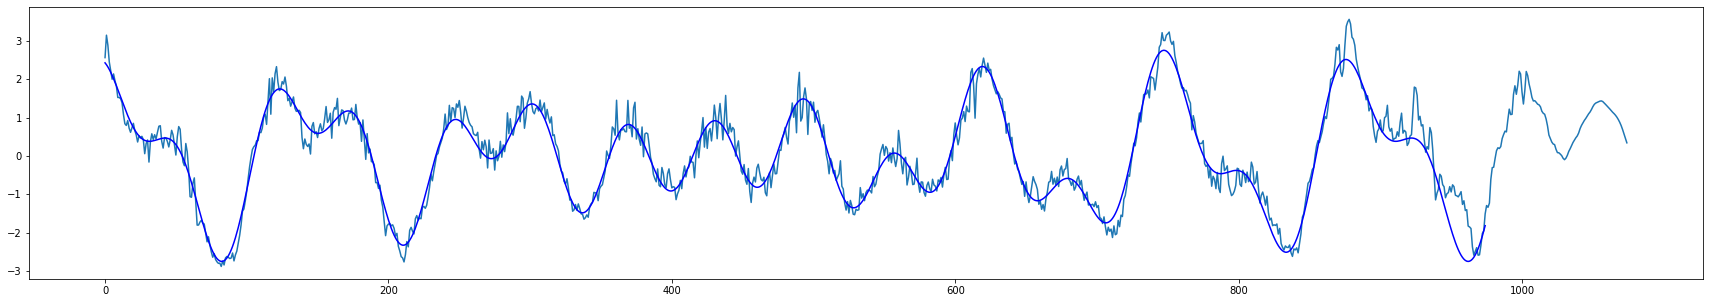

In [366]:
len(r[1])
# plt.plot(r[1][0])

plt.plot(r[1][0][:], label="Full")
plt.plot(base_y[25:], color="b")
# plt.plot(res.fittedvalues)
plt.show()

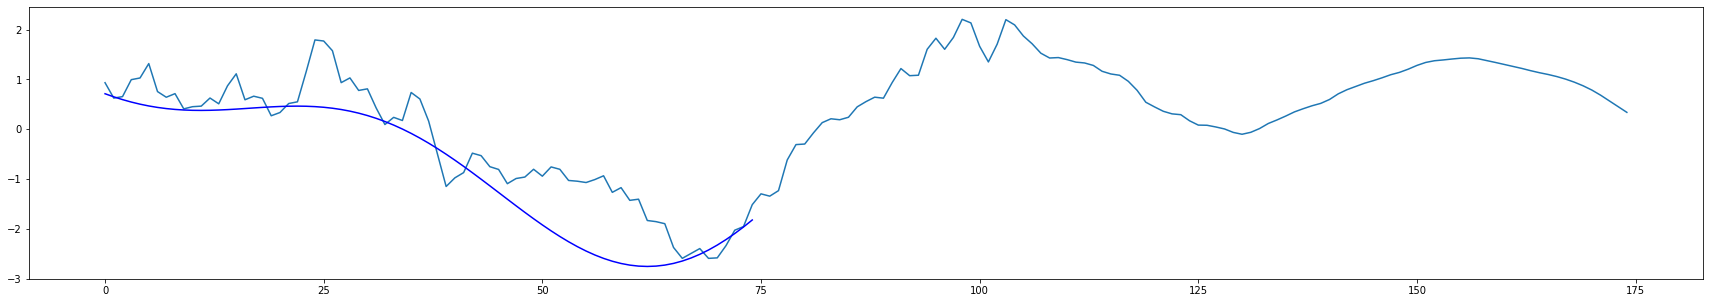

In [368]:
plt.plot(r[1][0][900:], label="Full")
plt.plot(base_y[925:], color="b")
# plt.plot(res.fittedvalues)
plt.show()

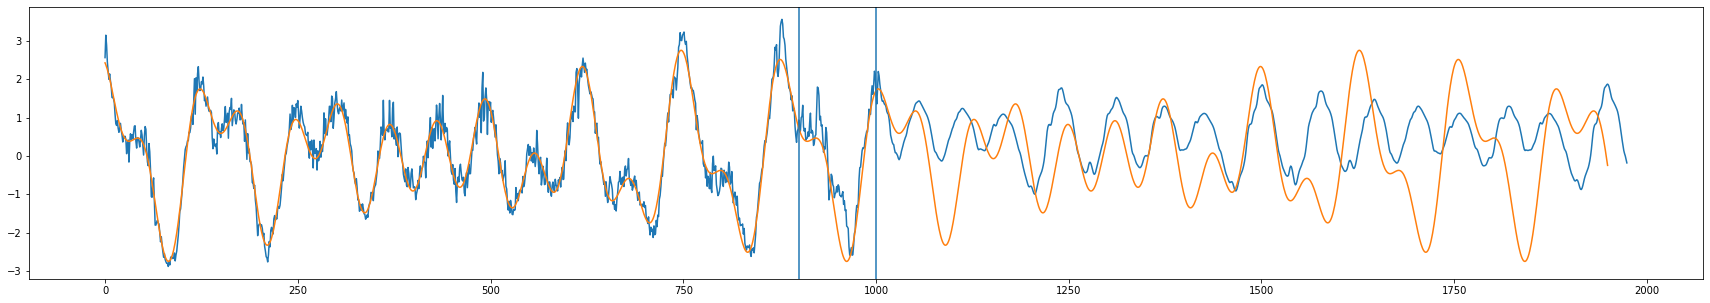

In [388]:
with torch.no_grad():
    future = 1000
    pred = model(torch.cat([newTrainX, newTestX], dim=0), future_preds=future)
    # print(pred[0])
    bigPred = pred[0].detach().numpy()

N = len(y) # number of samples
T1 = 20 # width of the wave
M1 = 1

T2 = 7
M2 = 0.7

T3 = 27
M3 = 0.3

stDev = 0.5 # Strength of noise
averageMovement = 4


new_x = np.arange(N) / N
new_base_y = np.sin(np.arange(N)*M1/T1).astype(np.float32)  \
       + np.sin(np.arange(N)*M2/T2).astype(np.float32) \
       + np.sin(np.arange(N)*M3/T2).astype(np.float32)

plt.plot(bigPred)
plt.plot(new_base_y[25:])
plt.axvline(x=900)
plt.axvline(x=1000)
plt.show()

In [402]:
num_features = 25
num_samples = len(y)

windowData = np.array(y[:num_features+1])
for i in range(1, num_samples - num_features):
    windowData = np.vstack((windowData, y[i:i+num_features+1]))

trainData = windowData[:-100]
testData = windowData[-100:]

newTrainX = torch.tensor(trainData[:,:-1], dtype=torch.float32)
newTrainY = torch.tensor(trainData[:,-1], dtype=torch.float32)

newTestX = torch.tensor(testData[:,:-1], dtype=torch.float32)
newTestY = torch.tensor(testData[:,-1], dtype=torch.float32)

model = LSTM_multifeature(input_features=num_features)
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.03)

# Train the model
r = training_loop_multifeature(10, model, optimiser, criterion, newTrainX, newTrainY, newTestX, newTestY)

Epoch:  0
Loss:  tensor(0.5467, grad_fn=<MseLossBackward0>)
Epoch:  1
Loss:  tensor(0.3447, grad_fn=<MseLossBackward0>)
Epoch:  2
Loss:  tensor(0.3017, grad_fn=<MseLossBackward0>)
Epoch:  3
Loss:  tensor(0.2801, grad_fn=<MseLossBackward0>)
Epoch:  4
Loss:  tensor(0.2642, grad_fn=<MseLossBackward0>)
Epoch:  5
Loss:  tensor(0.2537, grad_fn=<MseLossBackward0>)
Epoch:  6
Loss:  tensor(0.2439, grad_fn=<MseLossBackward0>)
Epoch:  7
Loss:  tensor(0.2340, grad_fn=<MseLossBackward0>)
Epoch:  8
Loss:  tensor(0.2249, grad_fn=<MseLossBackward0>)
Epoch:  9
Loss:  tensor(0.2170, grad_fn=<MseLossBackward0>)
torch.Size([1, 1075])
tensor([[ 2.3040,  3.2020,  2.7445,  ..., -0.4719, -0.3915, -0.3441]])


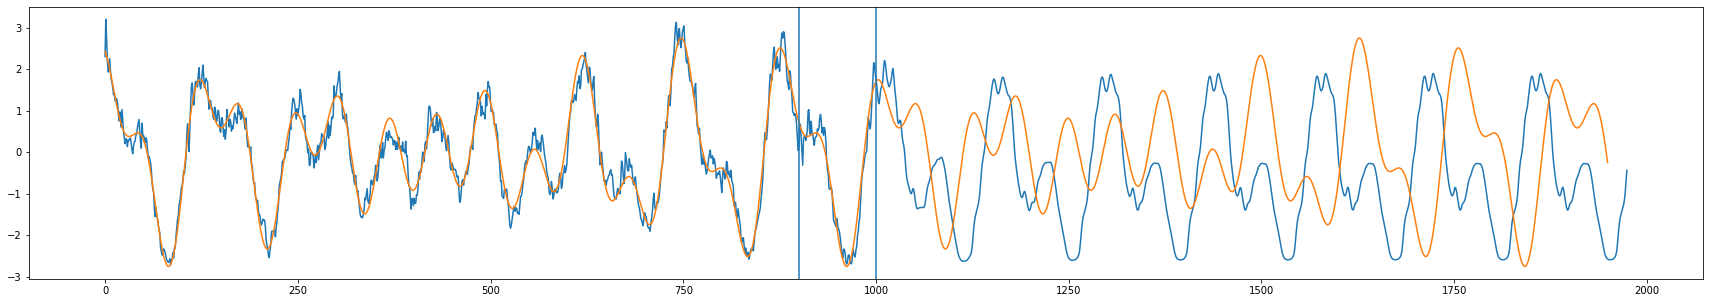

In [403]:
with torch.no_grad():
    future = 1000
    pred = model(torch.cat([newTrainX, newTestX], dim=0), future_preds=future)
    # print(pred[0])
    bigPred = pred[0].detach().numpy()


plt.plot(bigPred)
plt.plot(new_base_y[25:])
plt.axvline(x=900)
plt.axvline(x=1000)
plt.show()

In [412]:
N = 3000 # number of samples
T1 = 20 # width of the wave
M1 = 1

T2 = 7
M2 = 0.7

T3 = 25
M3 = 0.3

stDev = 0.5 # Strength of noise
averageMovement = 4


x = np.arange(N) / N
base_y = np.sin(np.arange(N)*M1/T1).astype(np.float32)  \
       + np.sin(np.arange(N)*M2/T2).astype(np.float32) \
       + np.sin(np.arange(N)*M3/T2).astype(np.float32)
y = base_y + np.random.normal(loc=0, scale=stDev, size=N) # Add noise to sample

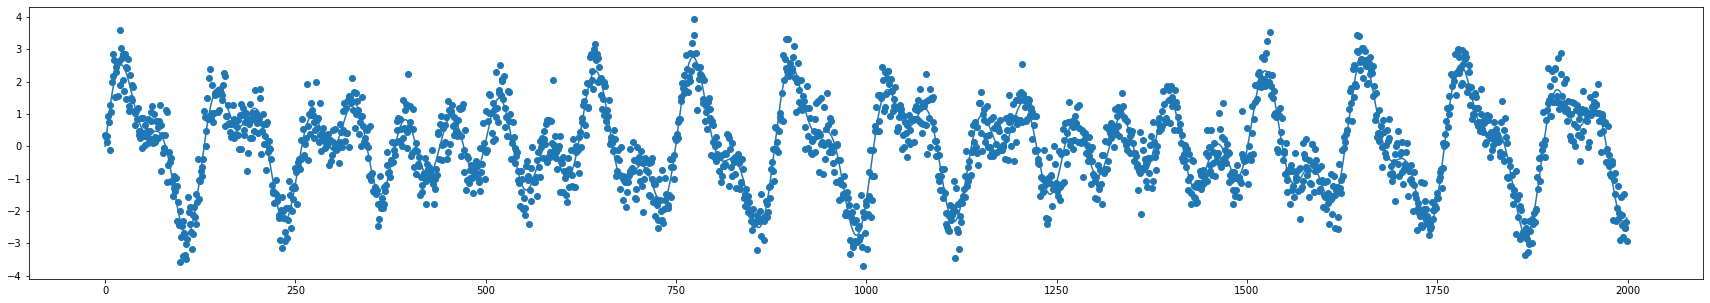

In [409]:
plt.plot(base_y)
plt.scatter(np.arange(N), y)

In [425]:
num_features = 25
num_samples = len(y)

windowData = np.array(y[:num_features+1])
for i in range(1, num_samples - num_features):
    windowData = np.vstack((windowData, y[i:i+num_features+1]))

trainData = windowData[:-1100]
testData = windowData[-1100:-1000]

newTrainX = torch.tensor(trainData[:,:-1], dtype=torch.float32)
newTrainY = torch.tensor(trainData[:,-1], dtype=torch.float32)

newTestX = torch.tensor(testData[:,:-1], dtype=torch.float32)
newTestY = torch.tensor(testData[:,-1], dtype=torch.float32)

model = LSTM_multifeature(input_features=num_features)
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.08)

# Train the model
r = training_loop_multifeature(10, model, optimiser, criterion, newTrainX, newTrainY, newTestX, newTestY)

Epoch:  0
Loss:  tensor(0.4005, grad_fn=<MseLossBackward0>)
Epoch:  1
Loss:  tensor(0.3032, grad_fn=<MseLossBackward0>)
Epoch:  2
Loss:  tensor(0.2853, grad_fn=<MseLossBackward0>)
Epoch:  3
Loss:  tensor(0.2766, grad_fn=<MseLossBackward0>)
Epoch:  4
Loss:  tensor(0.2717, grad_fn=<MseLossBackward0>)
Epoch:  5
Loss:  tensor(0.2663, grad_fn=<MseLossBackward0>)
Epoch:  6
Loss:  tensor(0.2616, grad_fn=<MseLossBackward0>)
Epoch:  7
Loss:  tensor(0.2563, grad_fn=<MseLossBackward0>)
Epoch:  8
Loss:  tensor(0.2497, grad_fn=<MseLossBackward0>)
Epoch:  9
Loss:  tensor(0.2452, grad_fn=<MseLossBackward0>)
torch.Size([1, 2075])
tensor([[ 1.6151,  2.0239,  2.1819,  ..., -2.5215, -2.4435, -2.3243]])


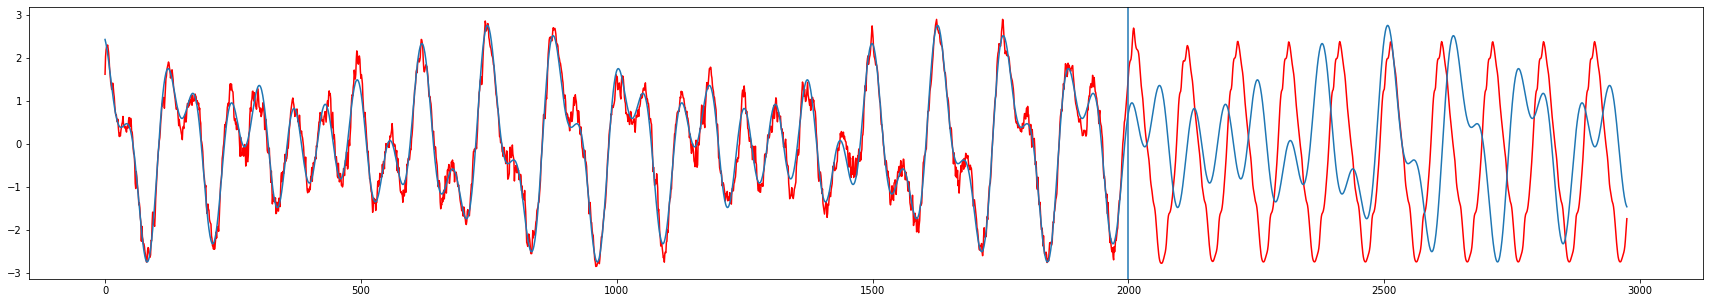

In [426]:
with torch.no_grad():
    future = 1000
    pred = model(torch.cat([newTrainX, newTestX], dim=0), future_preds=future)
    # print(pred[0])
    bigPred = pred[0].detach().numpy()


plt.plot(bigPred, color="r")
plt.plot(base_y[25:])
# plt.axvline(x=900)
plt.axvline(x=2000)
plt.show()

Epoch:  0
Loss:  tensor(0.4959, grad_fn=<MseLossBackward0>)
Epoch:  1
Loss:  tensor(0.3595, grad_fn=<MseLossBackward0>)
Epoch:  2
Loss:  tensor(0.3065, grad_fn=<MseLossBackward0>)
Epoch:  3
Loss:  tensor(0.2902, grad_fn=<MseLossBackward0>)
Epoch:  4
Loss:  tensor(0.2811, grad_fn=<MseLossBackward0>)
Epoch:  5
Loss:  tensor(0.2750, grad_fn=<MseLossBackward0>)
Epoch:  6
Loss:  tensor(0.2699, grad_fn=<MseLossBackward0>)
Epoch:  7
Loss:  tensor(0.2655, grad_fn=<MseLossBackward0>)
Epoch:  8
Loss:  tensor(0.2615, grad_fn=<MseLossBackward0>)
Epoch:  9
Loss:  tensor(0.2573, grad_fn=<MseLossBackward0>)
torch.Size([1, 2075])
tensor([[1.4794, 2.0398, 2.1587,  ..., 0.6042, 0.6037, 0.5989]])


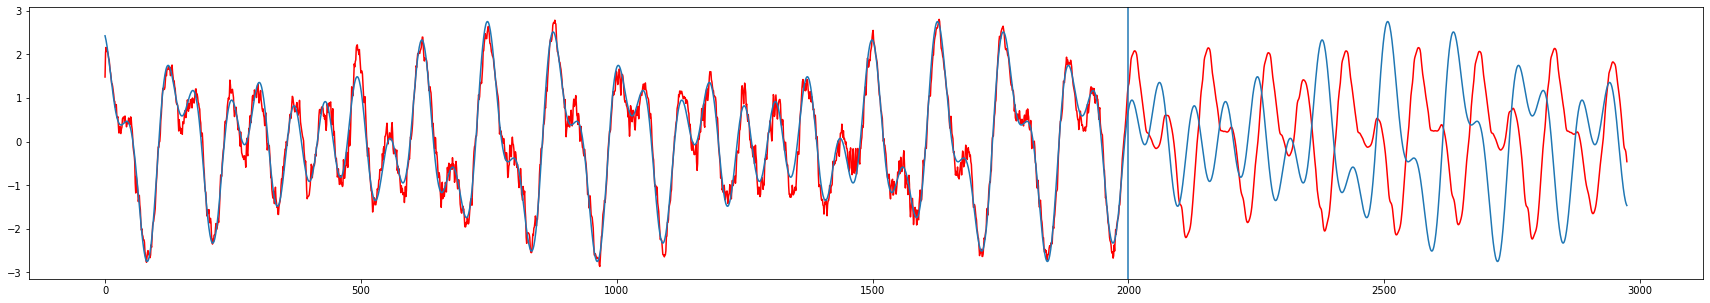

In [428]:
num_features = 25
num_samples = len(y)

windowData = np.array(y[:num_features+1])
for i in range(1, num_samples - num_features):
    windowData = np.vstack((windowData, y[i:i+num_features+1]))

trainData = windowData[:-1100]
testData = windowData[-1100:-1000]

newTrainX = torch.tensor(trainData[:,:-1], dtype=torch.float32)
newTrainY = torch.tensor(trainData[:,-1], dtype=torch.float32)

newTestX = torch.tensor(testData[:,:-1], dtype=torch.float32)
newTestY = torch.tensor(testData[:,-1], dtype=torch.float32)

model = LSTM_multifeature(input_features=num_features)
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.03)

# Train the model
r = training_loop_multifeature(10, model, optimiser, criterion, newTrainX, newTrainY, newTestX, newTestY)

with torch.no_grad():
    future = 1000
    pred = model(torch.cat([newTrainX, newTestX], dim=0), future_preds=future)
    # print(pred[0])
    bigPred = pred[0].detach().numpy()

plt.plot(bigPred, color="r")
plt.plot(base_y[25:])
# plt.axvline(x=900)
plt.axvline(x=2000)
plt.show()

Epoch:  0
Loss:  tensor(1.3090, grad_fn=<MseLossBackward0>)
Epoch:  1
Loss:  tensor(0.8470, grad_fn=<MseLossBackward0>)
Epoch:  2
Loss:  tensor(0.6147, grad_fn=<MseLossBackward0>)
Epoch:  3
Loss:  tensor(0.5137, grad_fn=<MseLossBackward0>)
Epoch:  4
Loss:  tensor(0.4409, grad_fn=<MseLossBackward0>)
Epoch:  5
Loss:  tensor(0.3888, grad_fn=<MseLossBackward0>)
Epoch:  6
Loss:  tensor(0.3510, grad_fn=<MseLossBackward0>)
Epoch:  7
Loss:  tensor(0.3312, grad_fn=<MseLossBackward0>)
Epoch:  8
Loss:  tensor(0.3191, grad_fn=<MseLossBackward0>)
Epoch:  9
Loss:  tensor(0.3097, grad_fn=<MseLossBackward0>)
torch.Size([1, 2075])
tensor([[ 0.2643,  0.7955,  1.1829,  ..., -1.4729, -1.4657, -1.4519]])


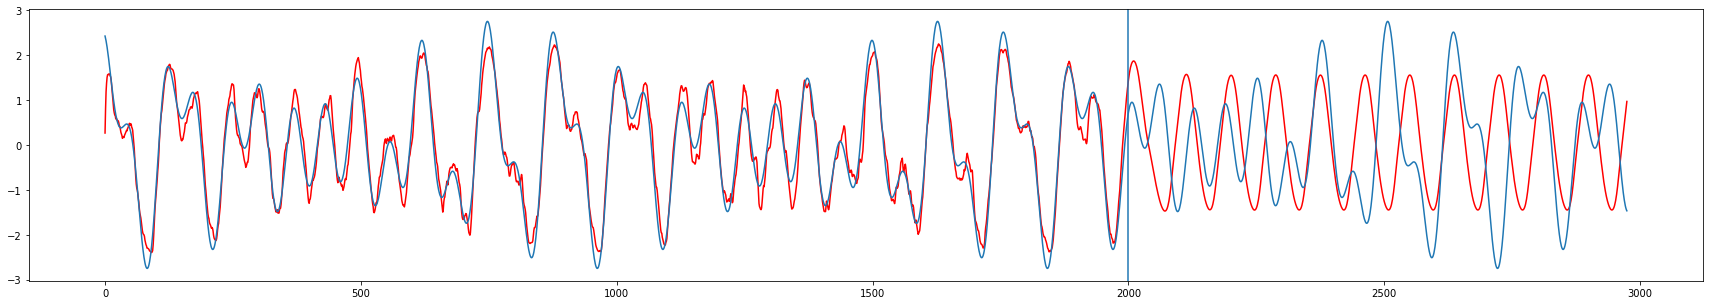

In [429]:
num_features = 25
num_samples = len(y)

windowData = np.array(y[:num_features+1])
for i in range(1, num_samples - num_features):
    windowData = np.vstack((windowData, y[i:i+num_features+1]))

trainData = windowData[:-1100]
testData = windowData[-1100:-1000]

newTrainX = torch.tensor(trainData[:,:-1], dtype=torch.float32)
newTrainY = torch.tensor(trainData[:,-1], dtype=torch.float32)

newTestX = torch.tensor(testData[:,:-1], dtype=torch.float32)
newTestY = torch.tensor(testData[:,-1], dtype=torch.float32)

model = LSTM_multifeature(input_features=num_features)
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.005)

# Train the model
r = training_loop_multifeature(10, model, optimiser, criterion, newTrainX, newTrainY, newTestX, newTestY)

with torch.no_grad():
    future = 1000
    pred = model(torch.cat([newTrainX, newTestX], dim=0), future_preds=future)
    # print(pred[0])
    bigPred = pred[0].detach().numpy()

plt.plot(bigPred, color="r")
plt.plot(base_y[25:])
# plt.axvline(x=900)
plt.axvline(x=2000)
plt.show()

Epoch:  0
Loss:  tensor(0.4569, grad_fn=<MseLossBackward0>)
Epoch:  1
Loss:  tensor(0.3330, grad_fn=<MseLossBackward0>)
Epoch:  2
Loss:  tensor(0.3042, grad_fn=<MseLossBackward0>)
Epoch:  3
Loss:  tensor(0.2915, grad_fn=<MseLossBackward0>)
Epoch:  4
Loss:  tensor(0.2825, grad_fn=<MseLossBackward0>)
Epoch:  5
Loss:  tensor(0.2766, grad_fn=<MseLossBackward0>)
Epoch:  6
Loss:  tensor(0.2721, grad_fn=<MseLossBackward0>)
Epoch:  7
Loss:  tensor(0.2689, grad_fn=<MseLossBackward0>)
Epoch:  8
Loss:  tensor(0.2648, grad_fn=<MseLossBackward0>)
Epoch:  9
Loss:  tensor(0.2608, grad_fn=<MseLossBackward0>)
torch.Size([1, 2075])
tensor([[1.1794, 1.9261, 2.2347,  ..., 0.3599, 0.4175, 0.4600]])


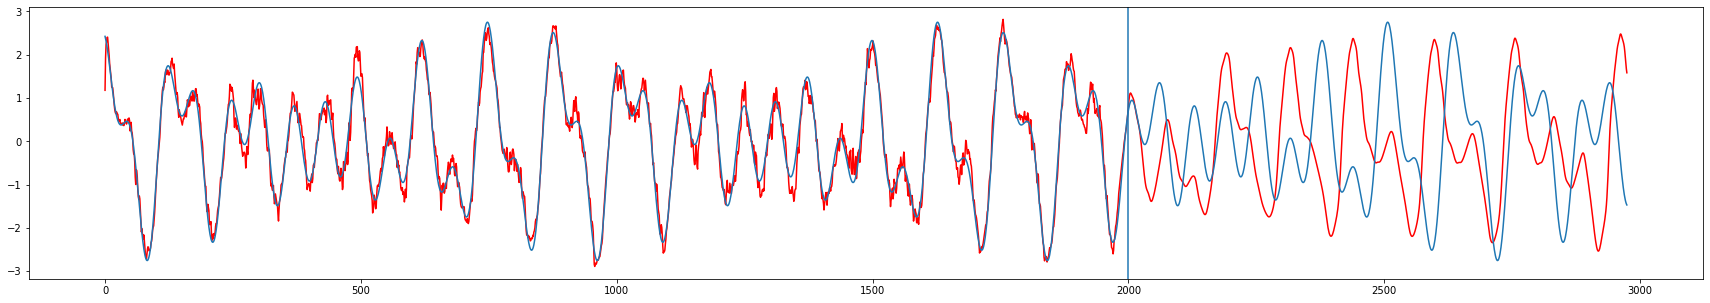

In [430]:
num_features = 25
num_samples = len(y)

windowData = np.array(y[:num_features+1])
for i in range(1, num_samples - num_features):
    windowData = np.vstack((windowData, y[i:i+num_features+1]))

trainData = windowData[:-1100]
testData = windowData[-1100:-1000]

newTrainX = torch.tensor(trainData[:,:-1], dtype=torch.float32)
newTrainY = torch.tensor(trainData[:,-1], dtype=torch.float32)

newTestX = torch.tensor(testData[:,:-1], dtype=torch.float32)
newTestY = torch.tensor(testData[:,-1], dtype=torch.float32)

model = LSTM_multifeature(input_features=num_features, hidden_layers_1=64, hidden_layers_2=64)
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.03)

# Train the model
r = training_loop_multifeature(10, model, optimiser, criterion, newTrainX, newTrainY, newTestX, newTestY)

with torch.no_grad():
    future = 1000
    pred = model(torch.cat([newTrainX, newTestX], dim=0), future_preds=future)
    # print(pred[0])
    bigPred = pred[0].detach().numpy()

plt.plot(bigPred, color="r")
plt.plot(base_y[25:])
# plt.axvline(x=900)
plt.axvline(x=2000)
plt.show()

In [433]:
class LSTM_multifeature(nn.Module):
    def __init__(self, input_features, hidden_layers_1=32, hidden_layers_2=32, hidden_layers_3=32):
        """ Instantiate the LSTM with multiple hidden layers
            In this case, I'm using two hidden layers, and a linear layer to convert the output to a single number """
        super(LSTM_multifeature, self).__init__()
        self.input_features = input_features
        self.hidden_layers_1 = hidden_layers_1
        self.hidden_layers_2 = hidden_layers_2
        self.hidden_layers_3 = hidden_layers_3
        self.lstm1 = nn.LSTMCell(self.input_features, self.hidden_layers_1)
        self.lstm2 = nn.LSTMCell(self.hidden_layers_1, self.hidden_layers_2)
        self.lstm3 = nn.LSTMCell(self.hidden_layers_2, self.hidden_layers_3)
        self.linear = nn.Linear(self.hidden_layers_3, 1)
        
        self.last_loss = 0  # For printing purposes during training
        
    def forward(self, y, future_preds=0):
        """ Call the model to make predictions
            h_t and c_t are the hidden and cell states of the lstm layers
            
            This forward function runs through the data one point at a time, and stores the models output for each point
            If future_preds > 0 is passed in, the model with make predictions based on its own output. It is currently very bad at this.
        """
        outputs, num_samples = [], y.shape[0]
        h_t = torch.zeros(1, self.hidden_layers_1, dtype=torch.float32)
        c_t = torch.zeros(1, self.hidden_layers_1, dtype=torch.float32)
        h_t2 = torch.zeros(1, self.hidden_layers_2, dtype=torch.float32)
        c_t2 = torch.zeros(1, self.hidden_layers_2, dtype=torch.float32)
        h_t3 = torch.zeros(1, self.hidden_layers_2, dtype=torch.float32)
        c_t3 = torch.zeros(1, self.hidden_layers_2, dtype=torch.float32)
        
        for time_step in y.split(1, dim=0):
            # print(time_step.shape)
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            h_t3, c_t3 = self.lstm2(h_t2, (h_t3, c_t3)) # new hidden and cell states
            output = self.linear(h_t3) # output from the last FC layer
            outputs.append(output)
        
        new_input = torch.cat([time_step[0], output[0]], dim=0)[1:].reshape(1, 25)
        for i in range(future_preds):
            # Mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(new_input, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            h_t3, c_t3 = self.lstm2(h_t2, (h_t3, c_t3))
            output = self.linear(h_t3)

            new_input = torch.cat([new_input[0], output[0]], dim=0)[1:].reshape(1, 25)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs

    
def training_loop_multifeature(n_epochs, model, optimiser, loss_fn, 
                  train_input, train_target, test_input, test_target):
    """ Train a model with provided data
        Ignorning the auto plotting part for now """
    for i in range(n_epochs):
        print("Epoch: ", i)
        def closure():
            optimiser.zero_grad()
            out = model(train_input)
            loss = loss_fn(out, train_target)
            # print("!")
            # print(out[:10])
            # print("-")
            # print(train_target[:10])
            loss.backward()
            model.last_loss = loss
            return loss
        
        optimiser.step(closure)
        print("Loss: ", model.last_loss)
        
        # Make future predictions
    with torch.no_grad():
        future = len(test_target)
        pred = model(torch.cat([train_input, test_input], dim=0), future_preds=future)
        print(pred.shape)
        print(pred)
        loss = loss_fn(pred.reshape(pred.shape[1])[-future:], test_target)
        y = pred.detach().numpy()

    return (loss, y)

Epoch:  0
Loss:  tensor(1.4562, grad_fn=<MseLossBackward0>)
Epoch:  1
Loss:  tensor(0.9643, grad_fn=<MseLossBackward0>)
Epoch:  2
Loss:  tensor(0.6152, grad_fn=<MseLossBackward0>)
Epoch:  3
Loss:  tensor(0.4665, grad_fn=<MseLossBackward0>)
Epoch:  4
Loss:  tensor(0.3547, grad_fn=<MseLossBackward0>)
Epoch:  5
Loss:  tensor(0.3145, grad_fn=<MseLossBackward0>)
Epoch:  6
Loss:  tensor(0.2990, grad_fn=<MseLossBackward0>)
Epoch:  7
Loss:  tensor(0.2883, grad_fn=<MseLossBackward0>)
Epoch:  8
Loss:  tensor(0.2776, grad_fn=<MseLossBackward0>)
Epoch:  9
Loss:  tensor(0.2719, grad_fn=<MseLossBackward0>)
torch.Size([1, 2075])
tensor([[0.5988, 1.6928, 2.2080,  ..., 0.0746, 0.1581, 0.2393]])


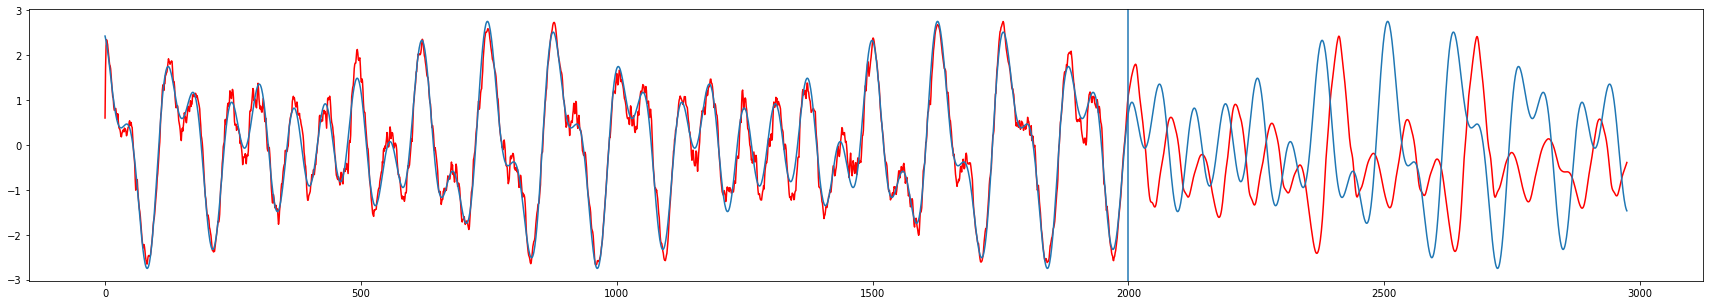

In [434]:
num_features = 25
num_samples = len(y)

windowData = np.array(y[:num_features+1])
for i in range(1, num_samples - num_features):
    windowData = np.vstack((windowData, y[i:i+num_features+1]))

trainData = windowData[:-1100]
testData = windowData[-1100:-1000]

newTrainX = torch.tensor(trainData[:,:-1], dtype=torch.float32)
newTrainY = torch.tensor(trainData[:,-1], dtype=torch.float32)

newTestX = torch.tensor(testData[:,:-1], dtype=torch.float32)
newTestY = torch.tensor(testData[:,-1], dtype=torch.float32)

model = LSTM_multifeature(input_features=num_features, hidden_layers_1=32, hidden_layers_2=32, hidden_layers_3=32)
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.03)

# Train the model
r = training_loop_multifeature(10, model, optimiser, criterion, newTrainX, newTrainY, newTestX, newTestY)

with torch.no_grad():
    future = 1000
    pred = model(torch.cat([newTrainX, newTestX], dim=0), future_preds=future)
    # print(pred[0])
    bigPred = pred[0].detach().numpy()

plt.plot(bigPred, color="r")
plt.plot(base_y[25:])
# plt.axvline(x=900)
plt.axvline(x=2000)
plt.show()